# Graph Knowledge

A getting started Graph Knowlege in Neo4j

In [1]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%load_ext dotenv
%dotenv

In [4]:
import os
from langchain_community.graphs import Neo4jGraph

# it 

graph = Neo4jGraph()

ValueError: Cannot resolve address 1967cc36.databases.neo4j.io:7687

## Data Ingestion

Ingest Elizabeth I's Wikipedia page. We can utilize [LangChain Loaders](https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/) to fetch and split the documents from Wikipedia

In [9]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter

# Read the wikipedia article
raw_documents = WikipediaLoader(query="Elizabeth I").load()
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_documents[:3])

c:\Users\Danilo\Code\knowledge-graph\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Danilo\Code\knowledge-graph\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
print(documents[0])

page_content='Elizabeth I (7 September 1533 – 24 March 1603) was Queen of England and Ireland from 17 November 1558 until her death in 1603. She was the last monarch of the House of Tudor.\nElizabeth was the only surviving child of Henry VIII and Anne Boleyn, his second wife, who was executed when Elizabeth was two years old. Anne\'s marriage to Henry was annulled, and Elizabeth was declared illegitimate. Henry restored her to the line of succession when she was 10, via the Third Succession Act 1543. After Henry\'s death in 1547, Elizabeth\'s younger half-brother Edward VI ruled until his own death in 1553, bequeathing the crown to a Protestant cousin, Lady Jane Grey, and ignoring the claims of his two half-sisters, the Catholic Mary and the younger Elizabeth, in spite of statutes to the contrary. Edward\'s will was set aside within weeks of his death and Mary became queen, deposing and executing Jane. During Mary\'s reign, Elizabeth was imprisoned for nearly a year on suspicion of sup

To construct a graph based on the retrieved documents. Implement `LLMGraphTransformerModule` that simplifies constructing and storing a knowledge graph in a graph database.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125") # gpt-4-0125-preview occasionally has issues
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

The LLM graph transformers returns graph documents, which can be imported to Neo4j via the add_graph_documents method. The `baseEntityLabel` parameter assigns an additional __Entity__ label to each node, enhancing indexing and query performance. The `include_source` parameter links nodes to their originating documents, facilitating data traceability and context understanding.

In [10]:
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

# directly show the graph resulting from the given Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='500px', width='100%'))

## Hybrid Retrieval for RAG

After the graph generation, we will use a hybrid retrieval approach that combines vector and keyword indexes with graph retrieval for RAG applications.

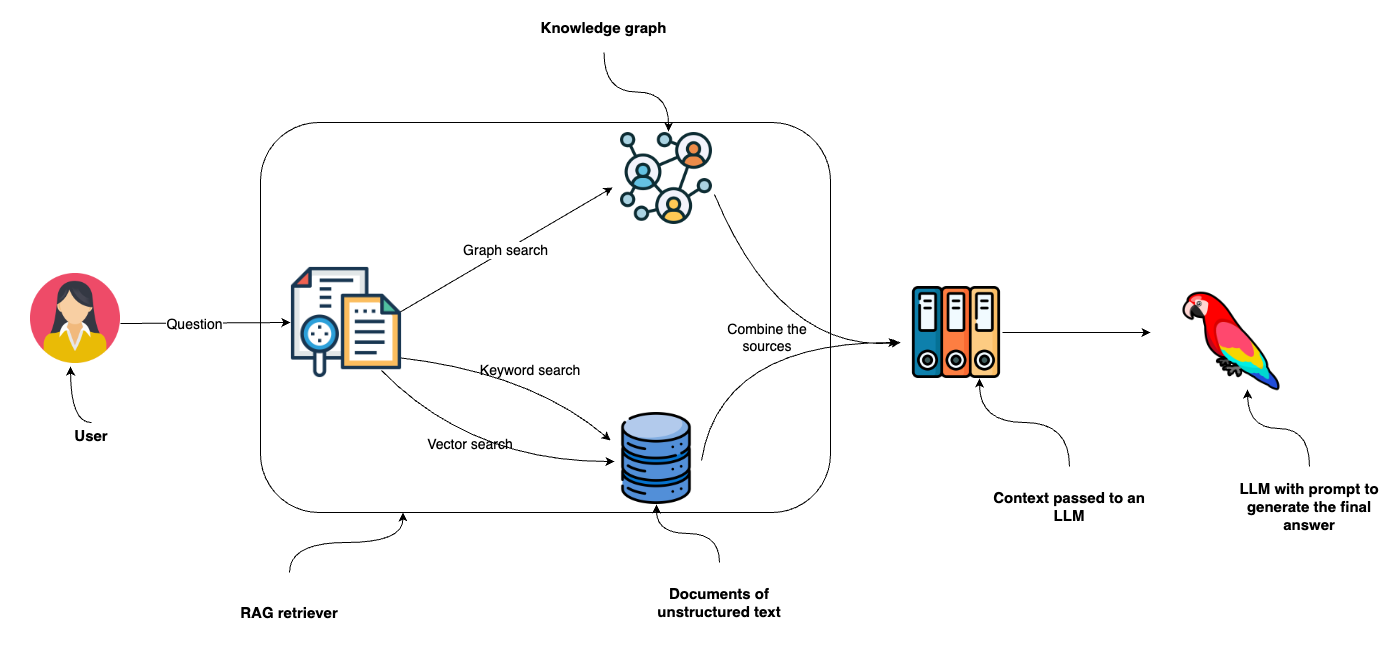

## Unstructured data retriever

You can use the `Neo4jVector.from_existing_graph` method to add both keyword and vector retrieval to documents. This method configures keyword and vector search indexes for a hybrid search approach, targeting nodes labeled Document. Additionally, it calculates text embedding values if they are missing.

In [ ]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

The graph retriever starts by identifying relevant entities in the input. For simplicity, we instruct the LLM to identify people, organizations, and locations. To achieve this, we will use LCEL with the newly added with_structured_output method to achieve this.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List, Optional
from langchain_core.prompts import ChatPromptTemplate

# Retriever

graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

In [ ]:
entity_chain.invoke({"question": "Where was Amelia Earhart born?"}).names

Great, now that we can detect entities in the question, let's use a full-text index to map them to the knowledge graph. First, we need to define a full-text index and a function that will generate full-text queries that allow a bit of misspelling, which we won't go into much detail here.

In [12]:
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars

def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

The `structured_retriever` function starts by detecting entities in the user question. Next, it iterates over the detected entities and uses a Cypher template to retrieve the neighborhood of relevant nodes. Let's test it out!

In [ ]:
print(structured_retriever("Who is Elizabeth I?"))

## Final retriever

We'll combine the unstructured and graph retriever to create the final context that will be passed to an LLM.

In [ ]:
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    return final_data

## Defining the RAG chain

We have successfully implemented the retrieval component of the RAG. First, we will introduce the query rewriting part that allows conversational follow up questions.

In [ ]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.output_parsers import StrOutputParser

# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""  # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x : x["question"]),
)

We introduce a prompt that leverages the context provided by the integrated hybrid retriever to produce the response, completing the implementation of the RAG chain.

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

Now, we can test our hybrid RAG implementation.

In [ ]:
chain.invoke({"question": "Which house did Elizabeth I belong to?"})

Test a follow up question

In [ ]:
chain.invoke(
    {
        "question": "When was she born?",
        "chat_history": [("Which house did Elizabeth I belong to?", "House Of Tudor")],
    }
)